In [1]:
%pip install -qU \
    langsmith==0.1.125 \
    langchain_openai \
    langchain_huggingface \
    langchain-core==0.2.41 \
    langchain \
    langchain_community \
    langchain-qdrant==0.1.4 \
    langchain-text-splitters \
    langchain-openai \
    langchain_huggingface \
    faiss-cpu \
    langchain-experimental \
    unstructured==0.15.7 \
    python-pptx==1.0.2 \
    nltk==3.9.1 \
    PyMuPDF==1.24.10 \
    ragas==0.1.18 \
    protobuf==3.20.3 \
    pyarrow==14.0.1 \
    fsspec==2024.6.1 \
    sentence_transformers \
    datasets \
    pyarrow==14.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.5 MB/s eta 0:00:00
   ━━

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
import getpass
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

os.environ["LANGCHAIN_PROJECT"] = "AIM-FINE-TUNING - AI Safety"
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

os.environ["QDRANT_API_KEY"] = getpass.getpass("Enter Your Qdrant API Key: ")
os.environ["QDRANT_URL"] = getpass.getpass("Enter Your Qdrant URL: ")


LangChain API Key:··········
OpenAI API Key:··········
Enter Your Qdrant API Key: ··········
Enter Your Qdrant URL: ··········


## Preparing Training documents

In [4]:
from langchain_experimental.text_splitter import SemanticChunker
from enum import Enum
from typing import List
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents import Document
import asyncio

class PDFLoaderWrapper():
    class LoaderType(str, Enum):
        PYMUPDF = "pymupdf"

    def __init__(self, file_path: str | List[str] , loader_type: LoaderType = LoaderType.PYMUPDF):
        self.file_path = file_path if isinstance(file_path, list) else [file_path]
        self.loader_type = loader_type

    async def aload(self) -> List[Document]:
        all_docs = []
        for file_path in self.file_path:
            if self.loader_type == self.LoaderType.PYMUPDF:
                try:
                    loader = PyMuPDFLoader(file_path)
                    docs = await loader.aload()
                    all_docs.extend(docs)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
                    continue
        return all_docs


In [9]:

BOR_FILE_PATH = "https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf"
NIST_FILE_PATH = "https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf"
SMALL_DOC = "https://arxiv.org/pdf/1908.10084"
documents_to_preload = [
    BOR_FILE_PATH,
    NIST_FILE_PATH
    # SMALL_DOC
]

pdf_loader = PDFLoaderWrapper(
    documents_to_preload, PDFLoaderWrapper.LoaderType.PYMUPDF
)
documents = await pdf_loader.aload()



In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap  = 50,
    length_function = len
)

In [10]:
training_documents = text_splitter.split_documents(documents)

In [11]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

In [12]:
import random

total_documents = len(training_documents)

# Define the split percentages
train_percent = 0.75  # 75% for training
val_percent = 0.125  # 12.5% for validation
test_percent = 0.125  # 12.5% for testing

# Shuffle the documents
random.shuffle(training_documents)

# Calculate the split indices
train_split = int(total_documents * train_percent)
val_split = int(total_documents * (train_percent + val_percent))

# Split the documents
training_split_documents = training_documents[:train_split]
val_split_documents = training_documents[train_split:val_split]
test_split_documents = training_documents[val_split:]

print(f"Training set: {len(training_split_documents)} documents")
print(f"Validation set: {len(val_split_documents)} documents")
print(f"Test set: {len(test_split_documents)} documents")


Training set: 343 documents
Validation set: 57 documents
Test set: 58 documents


## Constructing a Fine-Tuning dataset

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

qa_chat_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.
Check internet the question that you generate is realistic and asked by online users and
include only such questions in the output to be realistic.
You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

question_generation_chain = qa_prompt_template | qa_chat_model

In [14]:
import tqdm
def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}
  for document in tqdm.tqdm(documents):
    document_content = {"context" : document.page_content, "questions" : []}
    questions_generated = question_generation_chain.invoke({"context": document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]
  return questions, relevant_docs

In [15]:
training_questions, training_relevant_contexts = create_questions(training_split_documents,10)
len(training_questions)

100%|██████████| 343/343 [17:21<00:00,  3.04s/it]


3430

In [16]:
import json

# Specify the filename where you want to save the JSON
filename = 'training_questions.json'

# Write the dictionary to a JSON file
with open(filename, 'w') as json_file:
    json.dump(training_questions, json_file)

print(f"Data saved to {filename}")


Data saved to training_questions.json


In [17]:
val_questions, val_relevant_contexts = create_questions(val_split_documents,2)
len(val_questions)

100%|██████████| 57/57 [01:10<00:00,  1.24s/it]


114

In [18]:
import json

# Specify the filename where you want to save the JSON
filename = 'val_questions.json'

# Write the dictionary to a JSON file
with open(filename, 'w') as json_file:
    json.dump(val_questions, json_file)

print(f"Data saved to {filename}")


Data saved to val_questions.json


In [19]:
test_questions, test_relevant_contexts = create_questions(test_split_documents,2)
len(test_questions)

100%|██████████| 58/58 [01:05<00:00,  1.12s/it]


116

In [20]:
import json

# Specify the filename where you want to save the JSON
filename = 'test_questions.json'

# Write the dictionary to a JSON file
with open(filename, 'w') as json_file:
    json.dump(test_questions, json_file)

print(f"Data saved to {filename}")


Data saved to test_questions.json


In [22]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Fine-tuning `Snowflake/snowflake-arctic-embed-l`

In [23]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [24]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

# tourch DataLoader

loader = DataLoader(
    examples
)

# Using MultipleNegativesRankingLoss and MartyoshkaLoss for training

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

In [25]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [26]:
EPOCHS = 5

In [47]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic-embedd-l',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50,
)

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:
arctic_finetuned_model = SentenceTransformer("finetuned_arctic-embedd-l")

arctic_finetuned_model.push_to_hub("finetuned_arctic-embedd-l")

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic-embedd-l and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/jeevanions/finetuned_arctic-embedd-l/commit/b2f350382640efcaf1bb552a2c910417076a3158'

In [31]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

We are taking 3 models for comparison
1. text-embedding-3-small
2. Snowflake/snowflake-arctic-embed-l(base)
3. Snowflake/snowflake-arctic-embed-l(fine-tuned)

#### Evaluating `text-embedding-3-small`

In [32]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 116/116 [00:46<00:00,  2.51it/s]


In [33]:
te3_results_df = pd.DataFrame(te3_results)
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

0.9741379310344828

#### Evaluating `Snowflake/snowflage-arctic-embed-l`

In [42]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_l_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 116/116 [00:03<00:00, 35.27it/s]


In [53]:
arctic_embed_l_results_df = pd.DataFrame(arctic_embed_l_results)

In [54]:
arctic_embed_l_hit_rate = arctic_embed_l_results_df["is_hit"].mean()
arctic_embed_l_hit_rate

0.5948275862068966

#### Evaluating `Snowflake/snowflage-arctic-embed-l` (fine-tuned)

In [49]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic-embedd-l")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic-embedd-l and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 116/116 [00:02<00:00, 41.91it/s]


In [50]:
finetune_results_df = pd.DataFrame(finetune_results)

In [51]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

0.603448275862069

# Checking the models with rag

In [52]:
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

# using the training_documents which already loaded as split documents
def create_rag_chain(huggingface_embeddings):

    vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 6})

    RAG_PROMPT = """\
    Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

    Context:
    {context}

    Question:
    {question}

    Answer:
    """

    rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

    rag_llm =  ChatOpenAI(
        model="gpt-4o",
        temperature=0
    )

    rag_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
    )
    return rag_chain

In [55]:
base_rag_chain = create_rag_chain(huggingface_embeddings)
fine_tuned_rag_chain = create_rag_chain(finetune_embeddings)

In [57]:
# Try some questions here
base_rag_chain.invoke({"question":"What are the key steps to obtain input from stakeholder communities to identify unacceptable use in AI systems?"})

{'response': 'The provided context does not explicitly detail the key steps to obtain input from stakeholder communities to identify unacceptable use in AI systems. However, it does mention the importance of receiving community input into the design and use of technologies, public reporting on crucial elements of these systems, and ensuring privacy based on context and use case. \n\nTo summarize, while the exact steps are not provided, the context suggests that obtaining input from stakeholder communities involves:\n1. Engaging with the community to gather their input on the design and use of AI technologies.\n2. Publicly reporting on crucial elements of AI systems.\n3. Ensuring privacy and consent procedures are contextually appropriate.\n\nFor a more detailed and specific set of steps, additional information from the document or other sources would be required.',
 'context': [Document(metadata={'source': 'https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-

In [58]:
fine_tuned_rag_chain.invoke({"question":"What are the key steps to obtain input from stakeholder communities to identify unacceptable use in AI systems?"})

{'response': 'The key steps to obtain input from stakeholder communities to identify unacceptable use in AI systems, as outlined in the provided context, include:\n\n1. **Receiving Community Input**: Engaging with the community to gather their input on the design and use of AI technologies.\n2. **Public Reporting**: Providing public reports on crucial elements of AI systems to ensure transparency.\n3. **Better Notice and Consent Procedures**: Implementing procedures that ensure privacy based on context and use case.\n4. **Ability to Opt-Out**: Allowing individuals to opt-out of using AI systems and providing a fallback to a human process.\n5. **Providing Explanations**: Offering explanations of decisions made by AI systems and how these systems work.\n6. **Governance and Training**: Ensuring proper governance and training in the use of AI systems.\n7. **Local Validation**: Ensuring that technological use cases are genuinely related to the goal task and are locally validated to work.\n8

# RAGAS Evaluation

In [59]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-4o")
critic_llm = ChatOpenAI(model="gpt-4o")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

In [60]:
# We are going to use the test_split_documents that we created earlier
testset = generator.generate_with_langchain_docs(test_split_documents, test_size=20, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

embedding nodes:   0%|          | 0/116 [00:00<?, ?it/s]

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

In [61]:
testset.to_pandas().head()

question  \
0  What is the focus of the 2014 Federal Trade Co...   
1  What adverse impacts should be assessed during...   
2  What are the expectations for automated system...   
3  How should automated systems protect the publi...   
4  How can integrating pre- and post-deployment e...   

                                            contexts  \
0  [ENDNOTES\n57. ISO Technical Management Board....   
1  [32 \nMEASURE 2.6: The AI system is evaluated ...   
2  [DATA PRIVACY \nWHAT SHOULD BE EXPECTED OF AUT...   
3  [SAFE AND EFFECTIVE \nSYSTEMS \nWHAT SHOULD BE...   
4  [While indirect feedback methods such as autom...   

                                        ground_truth evolution_type  \
0  The answer to given question is not present in...         simple   
1  Adverse impacts, including health and wellbein...         simple   
2  The expectations for automated systems in term...         simple   
3  Automated systems should protect the public fr...         simple   
4  Integrating pre- and post-deployment external ...         simple   

                                            metadata  episode_done  
0  [{'source': 'https://www.whitehouse.gov/wp-con...          True  
1  [{'source': 'https://nvlpubs.nist.gov/nistpubs...          True  
2  [{'source': 'https://www.whitehouse.gov/wp-con...          True  
3  [{'source': 'https://www.whitehouse.gov/wp-con...          True  
4  [{'source': 'https://nvlpubs.nist.gov/nistpubs...          True

In [62]:
from datasets import Dataset

def generate_answers(chain, testset):
  answers = []
  contexts = []
  questions = testset.to_pandas()["question"].values.tolist()
  ground_truths = testset.to_pandas()["ground_truth"].values.tolist()

  for question in tqdm.tqdm(questions):
    answer = chain.invoke({"question" : question})
    answers.append(answer["response"])
    contexts.append([context.page_content for context in answer["context"]])

  return Dataset.from_dict({
      "question" : questions,
      "answer" : answers,
      "contexts" : contexts,
      "ground_truth" : ground_truths
  })

In [63]:
base_dataset = generate_answers(base_rag_chain, testset)
finetune_dataset = generate_answers(fine_tuned_rag_chain, testset)

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [64]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
from ragas import evaluate

base_result = evaluate(
    base_dataset,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_recall,
        context_precision,
    ],
)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [65]:
base_result

{'faithfulness': 0.8086, 'answer_relevancy': 0.6274, 'context_recall': 0.6000, 'context_precision': 0.5127}

In [66]:
base_result.to_pandas().head()

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


question  \
0  What is the focus of the 2014 Federal Trade Co...   
1  What adverse impacts should be assessed during...   
2  What are the expectations for automated system...   
3  How should automated systems protect the publi...   
4  How can integrating pre- and post-deployment e...   

                                            contexts  \
0  [Data Privacy; Intellectual \nProperty, Priori...   
1  [organization’s business processes or other ac...   
2  [Data Privacy; Intellectual \nProperty, detail...   
3  [detailed steps toward actualizing these princ...   
4  [While indirect feedback methods such as autom...   

                                              answer  \
0  The focus of the 2014 Federal Trade Commission...   
1  The adverse impacts that should be assessed du...   
2  The provided context does not explicitly detai...   
3  Automated systems should protect the public fr...   
4  Integrating pre- and post-deployment external ...   

                                        ground_truth  faithfulness  \
0  The answer to given question is not present in...      0.000000   
1  Adverse impacts, including health and wellbein...      1.000000   
2  The expectations for automated systems in term...      1.000000   
3  Automated systems should protect the public fr...      0.857143   
4  Integrating pre- and post-deployment external ...      0.818182   

   answer_relevancy  context_recall  context_precision  
0          1.000000             1.0           0.000000  
1          0.998103             0.0           1.000000  
2          0.000000             0.0           0.583333  
3          0.947325             1.0           1.000000  
4          0.933981             1.0           1.000000

In [67]:
fine_tuned_result = evaluate(
    finetune_dataset,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_recall,
        context_precision,
    ],
)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [68]:
fine_tuned_result

{'faithfulness': 0.8133, 'answer_relevancy': 0.6215, 'context_recall': 0.5500, 'context_precision': 0.5238}

In [69]:
fine_tuned_result.to_pandas().head()

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


question  \
0  What is the focus of the 2014 Federal Trade Co...   
1  What adverse impacts should be assessed during...   
2  What are the expectations for automated system...   
3  How should automated systems protect the publi...   
4  How can integrating pre- and post-deployment e...   

                                            contexts  \
0  [Data Privacy; Intellectual \nProperty, Priori...   
1  [organization’s business processes or other ac...   
2  [Data Privacy; Intellectual \nProperty, detail...   
3  [detailed steps toward actualizing these princ...   
4  [While indirect feedback methods such as autom...   

                                              answer  \
0  The focus of the 2014 Federal Trade Commission...   
1  The adverse impacts that should be assessed du...   
2  The provided context does not explicitly detai...   
3  Automated systems should protect the public fr...   
4  Integrating pre- and post-deployment external ...   

                                        ground_truth  faithfulness  \
0  The answer to given question is not present in...      0.500000   
1  Adverse impacts, including health and wellbein...      1.000000   
2  The expectations for automated systems in term...      0.666667   
3  Automated systems should protect the public fr...      0.916667   
4  Integrating pre- and post-deployment external ...      1.000000   

   answer_relevancy  context_recall  context_precision  
0          1.000000             1.0           0.000000  
1          0.998103             0.0           1.000000  
2          0.000000             0.0           0.588889  
3          0.947325             1.0           1.000000  
4          0.933981             1.0           1.000000

In [71]:
!pip install -U matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
<ipython-input-80-cfc79a7d2302>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(merged_df['short_question'], rotation=90)
<ipython-input-80-cfc79a7d2302>:35: UserWarning: FixedFormatter sho

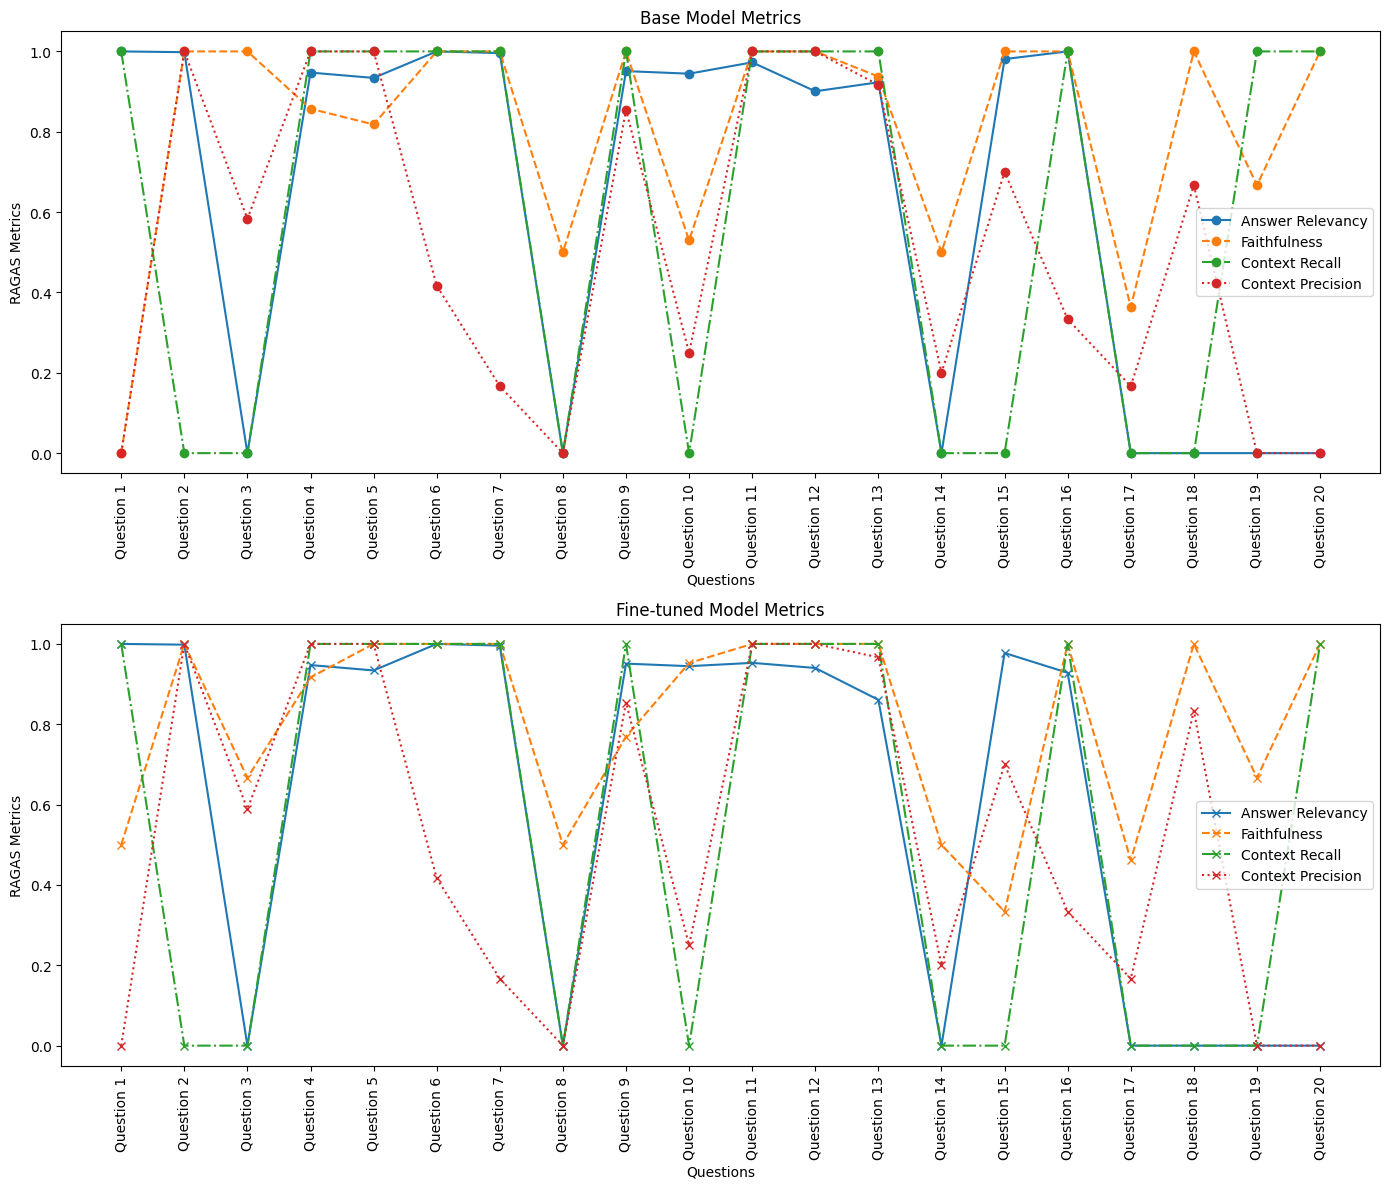

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframes here

# Merge on the 'question' column or another common identifier
merged_df = pd.merge(base_result.to_pandas(), fine_tuned_result.to_pandas(), on='question', suffixes=('_base', '_finetuned'))

# Create shortened question labels for readability
merged_df['short_question'] = ['Question ' + str(i + 1) for i in range(len(merged_df))]

# Plotting two subplots: one for base model and one for fine-tuned model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot for Base Model
ax1.plot(merged_df['short_question'], merged_df['answer_relevancy_base'], label='Answer Relevancy', marker='o')
ax1.plot(merged_df['short_question'], merged_df['faithfulness_base'], label='Faithfulness', marker='o', linestyle='--')
ax1.plot(merged_df['short_question'], merged_df['context_recall_base'], label='Context Recall', marker='o', linestyle='-.')
ax1.plot(merged_df['short_question'], merged_df['context_precision_base'], label='Context Precision', marker='o', linestyle=':')
ax1.set_title('Base Model Metrics')
ax1.set_xlabel('Questions')
ax1.set_ylabel('RAGAS Metrics')
ax1.legend()
ax1.set_xticklabels(merged_df['short_question'], rotation=90)

# Plot for Fine-tuned Model
ax2.plot(merged_df['short_question'], merged_df['answer_relevancy_finetuned'], label='Answer Relevancy', marker='x')
ax2.plot(merged_df['short_question'], merged_df['faithfulness_finetuned'], label='Faithfulness', marker='x', linestyle='--')
ax2.plot(merged_df['short_question'], merged_df['context_recall_finetuned'], label='Context Recall', marker='x', linestyle='-.')
ax2.plot(merged_df['short_question'], merged_df['context_precision_finetuned'], label='Context Precision', marker='x', linestyle=':')
ax2.set_title('Fine-tuned Model Metrics')
ax2.set_xlabel('Questions')
ax2.set_ylabel('RAGAS Metrics')
ax2.legend()
ax2.set_xticklabels(merged_df['short_question'], rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
<ipython-input-81-119747e82e97>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(merged_df['short_question'], rotation=90)
<ipython-input-81-119747e82e97>:45: UserWarning: FixedFormatter sho

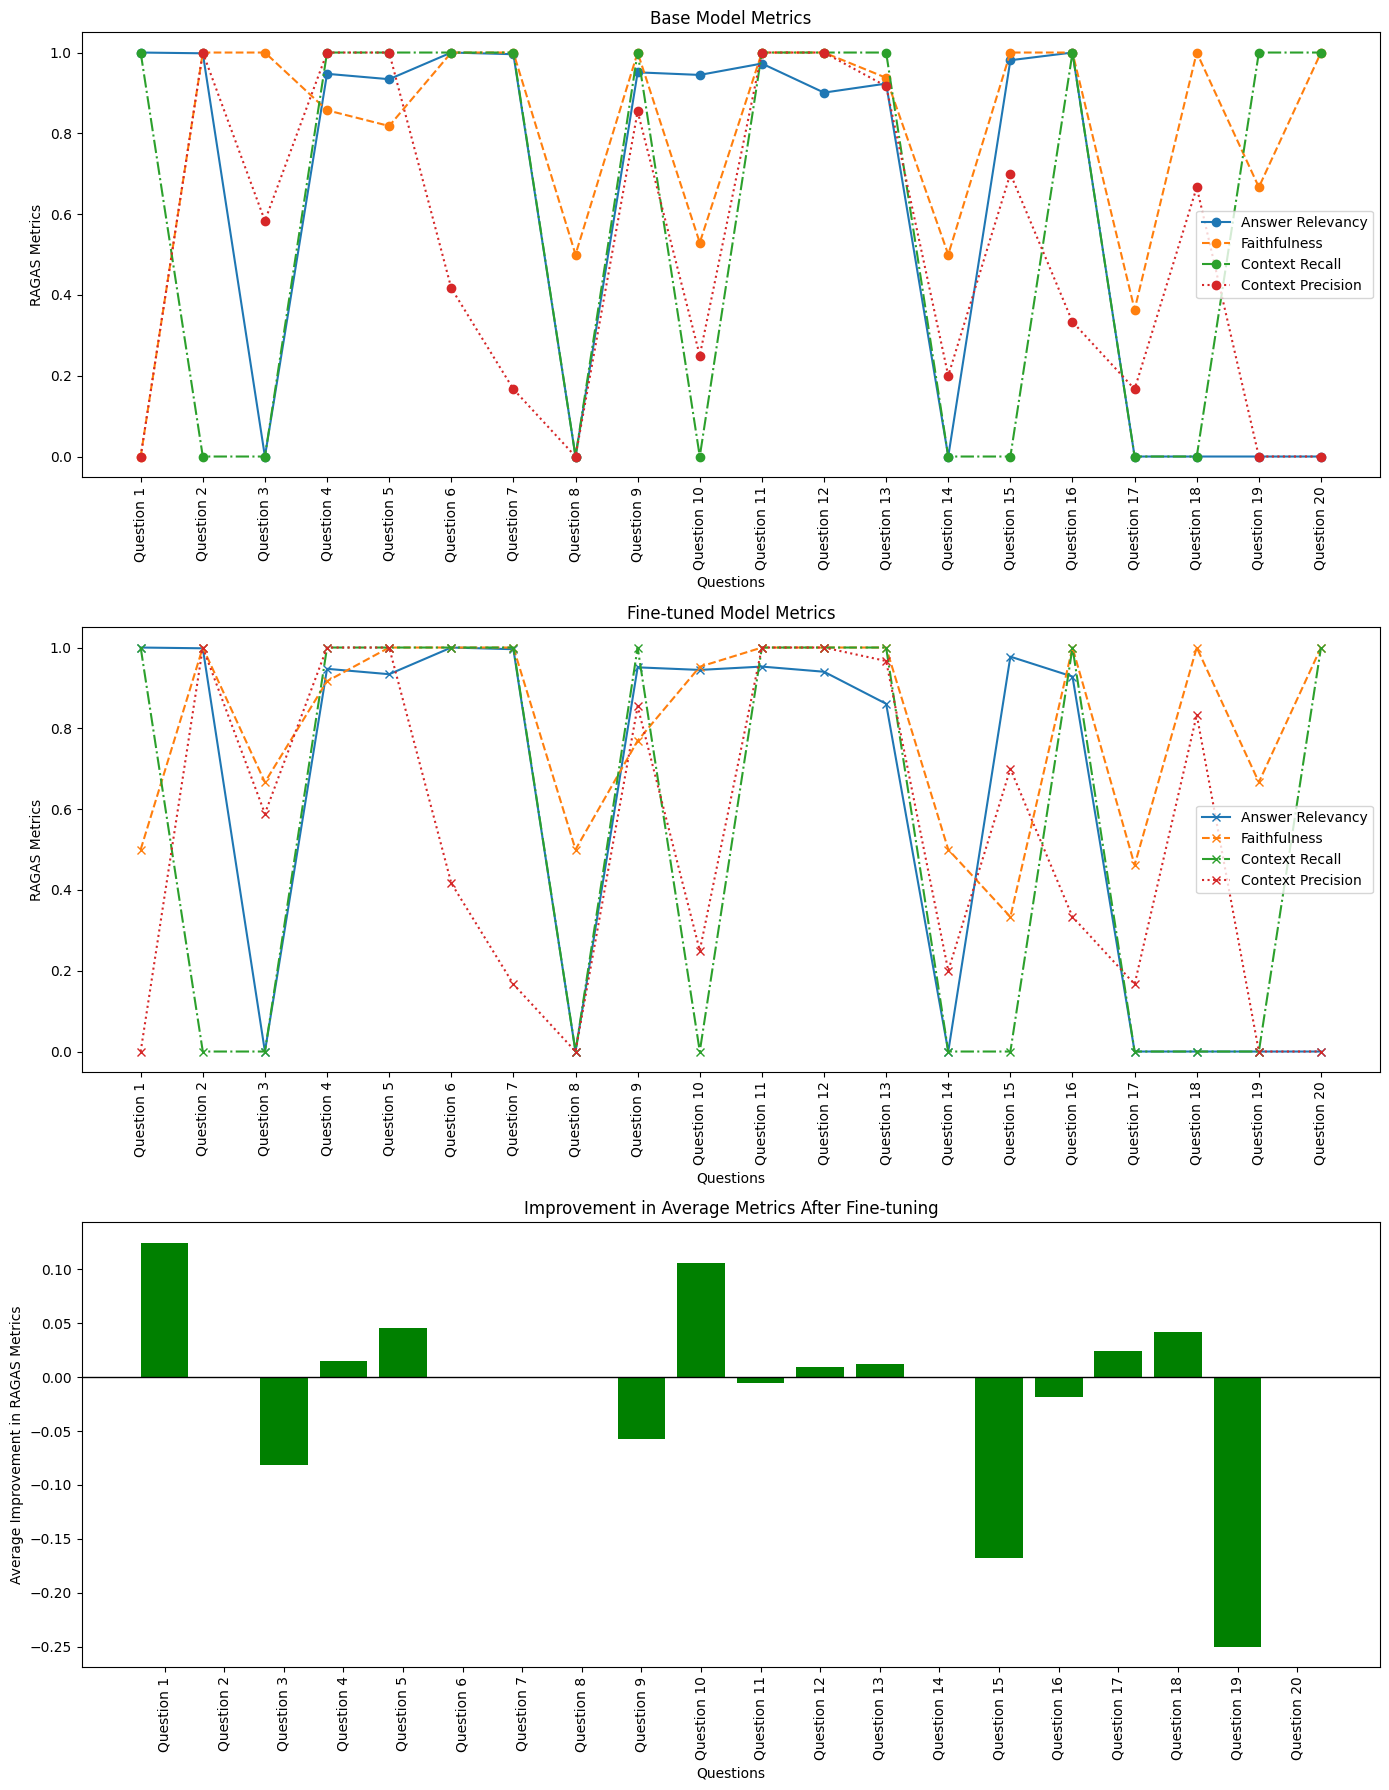

In [81]:
# Another go at the graph

import pandas as pd
import matplotlib.pyplot as plt

# Merge on the 'question' column or another common identifier
merged_df = pd.merge(base_result.to_pandas(), fine_tuned_result.to_pandas(), on='question', suffixes=('_base', '_finetuned'))

# Create shortened question labels for readability
merged_df['short_question'] = ['Question ' + str(i + 1) for i in range(len(merged_df))]

# Calculate improvements
merged_df['improvement_answer_relevancy'] = merged_df['answer_relevancy_finetuned'] - merged_df['answer_relevancy_base']
merged_df['improvement_faithfulness'] = merged_df['faithfulness_finetuned'] - merged_df['faithfulness_base']
merged_df['improvement_context_recall'] = merged_df['context_recall_finetuned'] - merged_df['context_recall_base']
merged_df['improvement_context_precision'] = merged_df['context_precision_finetuned'] - merged_df['context_precision_base']

# Average improvement across all metrics
merged_df['avg_improvement'] = merged_df[['improvement_answer_relevancy', 'improvement_faithfulness',
                                          'improvement_context_recall', 'improvement_context_precision']].mean(axis=1)

# Plotting three subplots: base, fine-tuned, and improvements
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# Plot for Base Model
ax1.plot(merged_df['short_question'], merged_df['answer_relevancy_base'], label='Answer Relevancy', marker='o')
ax1.plot(merged_df['short_question'], merged_df['faithfulness_base'], label='Faithfulness', marker='o', linestyle='--')
ax1.plot(merged_df['short_question'], merged_df['context_recall_base'], label='Context Recall', marker='o', linestyle='-.')
ax1.plot(merged_df['short_question'], merged_df['context_precision_base'], label='Context Precision', marker='o', linestyle=':')
ax1.set_title('Base Model Metrics')
ax1.set_xlabel('Questions')
ax1.set_ylabel('RAGAS Metrics')
ax1.legend()
ax1.set_xticklabels(merged_df['short_question'], rotation=90)

# Plot for Fine-tuned Model
ax2.plot(merged_df['short_question'], merged_df['answer_relevancy_finetuned'], label='Answer Relevancy', marker='x')
ax2.plot(merged_df['short_question'], merged_df['faithfulness_finetuned'], label='Faithfulness', marker='x', linestyle='--')
ax2.plot(merged_df['short_question'], merged_df['context_recall_finetuned'], label='Context Recall', marker='x', linestyle='-.')
ax2.plot(merged_df['short_question'], merged_df['context_precision_finetuned'], label='Context Precision', marker='x', linestyle=':')
ax2.set_title('Fine-tuned Model Metrics')
ax2.set_xlabel('Questions')
ax2.set_ylabel('RAGAS Metrics')
ax2.legend()
ax2.set_xticklabels(merged_df['short_question'], rotation=90)

# Plot for Improvement
ax3.bar(merged_df['short_question'], merged_df['avg_improvement'], color='green')
ax3.set_title('Improvement in Average Metrics After Fine-tuning')
ax3.set_xlabel('Questions')
ax3.set_ylabel('Average Improvement in RAGAS Metrics')
ax3.axhline(0, color='black', linewidth=1)  # Add a line at y=0 for reference
ax3.set_xticklabels(merged_df['short_question'], rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
